In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()
plt.ion()

local
local
=== Running NVCC Compilation (cubin for ptxas info) ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --ptxas-options=-v -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_saved.cubin


ptxas info    : 0 bytes gmem, 144 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1104 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 59 registers, 1104 bytes cumulative stack size, 396 bytes cmem[0], 24 bytes cmem[2]


In [ ]:
@dataclass
class MegaDynamics(kgs.BaseClass):
    # Configuration
    n_trees = 40
    n_ensembles = 1000
    n_rounds = 5
    seed = 42
    plot_interval = None

    # Hyperparameters
    size_setup = 0.5 # will be mulitiplied by sqrt(n_trees)
    duration_init = 10.
    duration_compact = 200.
    duration_final = 100. # careful - lowering this can seem to make things better, but actually can mean overlapping solutions
    dt = 0.02
    scaling_area_start = 0.3
    scaling_area_end = 0.001
    scaling_boundary = 5.
    scaling_overlap = 1. # recommend to keep this fixed
    use_boundary_distance = True

    def run_simulation(self):
        # Initial configuration
        size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
        xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
        xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
        xyt = np.array(xyt, dtype=np.float32)
        h = np.array([[2*size_setup_scaled]*self.n_ensembles], dtype=np.float32).T
        cost = pack_cost.CostCompound(costs=[pack_cost.AreaCost(scaling=0.), 
                                             pack_cost.BoundaryDistanceCost(scaling=self.scaling_boundary), 
                                             pack_cost.CollisionCostOverlappingArea(self.scaling_overlap)])

        if self.plot_interval is not None:
            fig, ax = plt.subplots(figsize=(8, 8))
            tree_list = kgs.TreeList()
            print(xyt[0].shape)
            tree_list.xyt = xyt[0]
            pack_vis.visualize_tree_list(tree_list, ax=ax, h=size_setup_scaled)
            display(fig)
            clear_output(wait=True)

        xyt = cp.array(xyt)
        h = cp.array(h)
        

        t_total = np.float32(0.)
        dt = np.float32(self.dt)
        phase = 'init'
        t_this_phase = np.float32(0.)
        while True:
            total_cost, total_grad, bound_grad = cost.compute_cost(xyt, h)
            break


            
                                                       


AssertionError: 

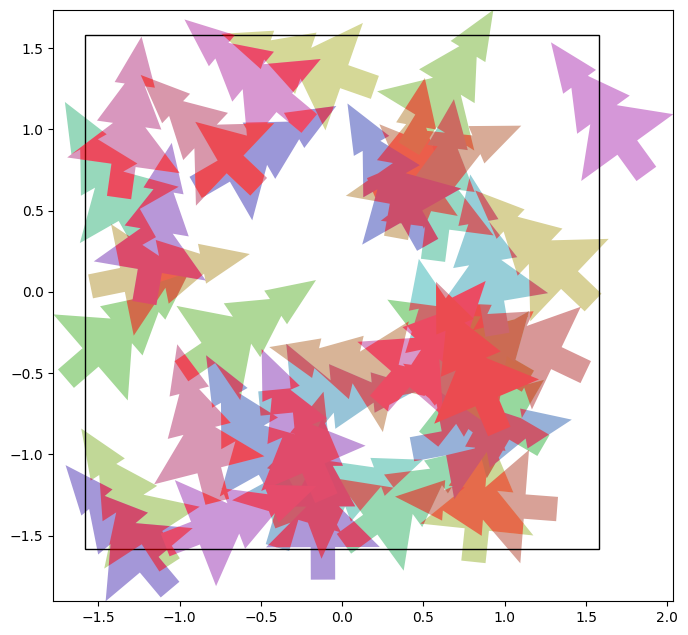

In [ ]:
runner = MegaDynamics()
runner.plot_interval = 1.
runner.run_simulation()